# Importing Libraries 

In [1]:
!pip install implicit

You should consider upgrading via the 'C:\Users\zhuzh\OneDrive\Desktop\AI Facial recognition\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances
import seaborn as sns
import implicit 
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'white')

# Data Preprocessing


In [3]:
df_style=pd.read_csv('StylePreferences.csv')
df_style.drop(['UserID','Top 6 most preferred style','sum'], axis=1, inplace=True)

In [4]:
df_style = df_style.fillna(0)

one style from each user has been selected as the test data and the index of the column that represents the selected style is saved in a list.

In [5]:
grp_dict={}
test_data={}
grp = df_style.groupby(['Gender','Age Group'])
for name, df in grp:
    df.drop(['Gender','Age Group'], axis=1, inplace=True)
    df=df.reset_index().drop(['index'],axis=1)
    df_mat=np.array(df)
    test_indxs=[]
    ### extract test data ###
    for i in range(len(df)):
        indxs=np.where(np.array(df.iloc[i])==1)[0]
        test_indx=np.random.choice(indxs, size=1)[0]
        df_mat[i][test_indx]=0
        test_indxs.append(test_indx)
    ##########################
    test_data[name]=test_indxs
    grp_dict[name]=df_mat
keys=list(grp_dict.keys())
styles=np.array(df.columns)

In [6]:
df_anly=df_style.groupby(['Gender','Age Group']).sum().reset_index()

In [7]:
df_anly['group id']=[i for i in range(len(df_anly))]

## model1 (features from user-style matrix & cosine similarity)


vectors in the user-style matrix have been directly used as feature vectors

vectors of style 1 =[0,1,0], style 2=[0,1,1],style 3=[1,1,0]

In [8]:
sim_mat_dic_m1={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    style_similarity_matrix=cosine_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m1[keys[i]]=style_similarity_matrix

## model 2 (features from Svd & cosine similarity)

svd to generate feature vectors

In [9]:
sim_mat_dic_m2={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    R = np.array(df).T
    mean = np.mean(R, axis = 1)
    data_matrix = R - mean.reshape(-1, 1)
    U, sigma, Vt = svds(data_matrix, k = np.min(data_matrix.shape)-1)
    sigma = np.diag(sigma)
    feature_matrix=np.dot(U, sigma)
    style_similarity_matrix=cosine_similarity(feature_matrix,feature_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m2[keys[i]]=style_similarity_matrix

## Model3 (features from user-style matrix & euclidean distance similarity)

In [10]:
def euclidean_similarity(matrix1,matrix2):
    euclidean_dist=euclidean_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # 
    euclidean_dist_scaled = scaler.fit_transform(euclidean_dist)
    euclidean_sim=1-euclidean_dist_scaled #minus 1 to find similarity 
    return(euclidean_sim)

In [11]:
sim_mat_dic_m3={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    style_similarity_matrix=euclidean_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on ed similarity
    sim_mat_dic_m3[keys[i]]=style_similarity_matrix

## Model4 (features from user-style matrix & manhattan distance similarity)

In [12]:
def manhattan_similarity(matrix1,matrix2):
    manhattan_dist=manhattan_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # transform data
    manhattan_dist_scaled = scaler.fit_transform(manhattan_dist)
    manhattan_sim=1-manhattan_dist_scaled #minus 1 to find similarity 
    return(manhattan_sim)


In [13]:
sim_mat_dic_m5={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    style_similarity_matrix= manhattan_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on md similarity
    sim_mat_dic_m5[keys[i]]=style_similarity_matrix

# Evaluating models part

In [14]:
def rmse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.sqrt(np.mean((test-1)**2)) # calculation of  error
    return(err)

In [15]:
def mse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean((test-1)**2) # calculation of  error
    return(err)

In [16]:
def mape_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean(abs(test-1)) # calculation of  error
    return(err)

In [17]:
cosine_rmse=[]
svd_rmse=[]
euclidean_rmse=[]
mahanttan_rmse=[]


cosine_mse=[]
svd_mse=[]
euclidean_mse=[]
mahanttan_mse=[]


cosine_mape=[]
svd_mape=[]
euclidean_mape=[]
mahanttan_mape=[]


for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    style_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    style_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    style_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    style_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m5).T*(data_matrix==0)*weight

    #rmse 
    cosine_rmse.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_rmse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_rmse.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_rmse.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]])) 
  

    #mse
    cosine_mse.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_mse.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mse.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))
  

    #mape
    cosine_mape.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mape.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    euclidean_mape.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mape.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

In [18]:
rmse_m1=[]
rmse_m2=[]
rmse_m3=[]
rmse_m5=[]
mse_m1=[]
mse_m2=[]
mse_m3=[]
mse_m5=[]

mape_m1=[]
mape_m2=[]
mape_m3=[]
mape_m5=[]
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    food_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    food_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    food_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    food_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m5).T*(data_matrix==0)*weight
    rmse_m1.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    rmse_m2.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    rmse_m3.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    rmse_m5.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mse_m1.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mse_m2.append(mse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mse_m3.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mse_m5.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mape_m1.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mape_m2.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mape_m3.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mape_m5.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

values  be predicted using the this

**rating_**{(i,j)} = similarity\_matrix_i * data\_matrix_j*weight  


where, \


similarity\_matrix_i=$ i th raw of user_similarity_matrix\
 data\_matrix_j= j th column of data_matrix_useritem\
weight=1/sum(data\_matrix\_useritem_j !=0)



# Plotting Line Graph with markers at each point 

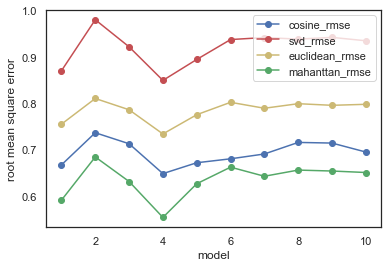

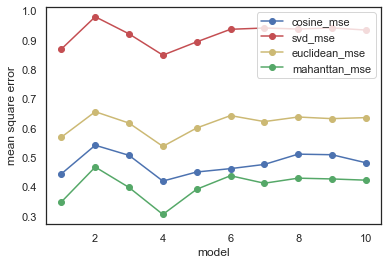

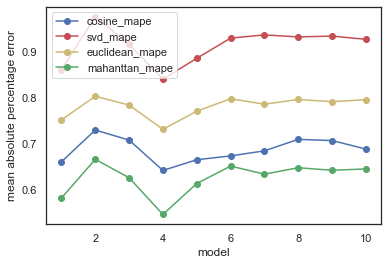

In [19]:
plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_rmse,'b',label='cosine_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_rmse,'r',label='svd_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_rmse,'y',label='euclidean_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_rmse,'g',label='mahanttan_rmse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mse,'b',label='cosine_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mse,'r',label='svd_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mse,'y',label='euclidean_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mse,'g',label='mahanttan_mse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mape,'b',label='cosine_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mape,'r',label='svd_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mape,'y',label='euclidean_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mape,'g',label='mahanttan_mape', marker = 'o')


plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

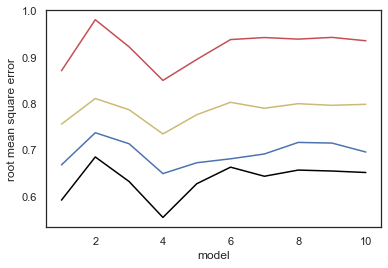

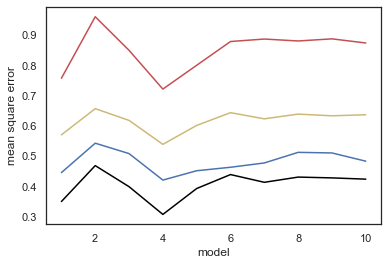

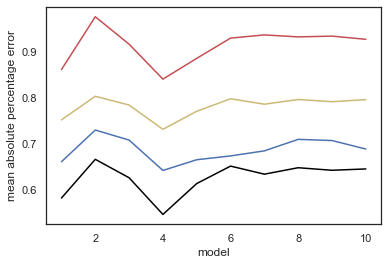

In [20]:
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m1,'b',label='rmse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m2,'r',label='rmse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m3,'y',label='rmse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m5,'black',label='rmse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(rmse_m1))],mse_m1,'b',label='mse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m2,'r',label='mse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m3,'y',label='mse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m5,'black',label='mse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(rmse_m1))],mape_m1,'b',label='mape_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m2,'r',label='mape_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m3,'y',label='mape_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m5,'black',label='mape_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

# **RMSE **

In [21]:
a=cosine_rmse
b=svd_rmse
c=euclidean_rmse
d=mahanttan_rmse

print(a)
print(b)
print(c)
print(d)

[0.667216688953126, 0.7365182841345645, 0.7127695908672468, 0.6484006048910815, 0.6718195976763961, 0.6803134129039737, 0.690708367031291, 0.7156420445445372, 0.7142530180606316, 0.6949192045743283]
[0.8702115752161876, 0.9801648725817976, 0.9217335675776023, 0.8493628583215752, 0.8945417801352877, 0.9374328179001588, 0.9417944907077496, 0.9383855670142912, 0.9421217122437472, 0.9348313355535032]
[0.7550335200046477, 0.8103668891612685, 0.786049162242961, 0.7339065234660882, 0.7754089156457902, 0.8021418385709038, 0.7893218882423696, 0.7991481510643853, 0.7956488241901686, 0.7978231928044107]
[0.5911615712150192, 0.6843104798884708, 0.6313416491135945, 0.5539373202964538, 0.6265493182702311, 0.6623145040790477, 0.642697079542784, 0.6560024841177176, 0.6539672045122111, 0.6507777522983351]


# **MSE Group**

In [22]:
a=cosine_mse
b=svd_mse
c=euclidean_mse
d=mahanttan_mse

print(a)
print(b)
print(c)
print(d)

[0.44517811001757257, 0.5424591828645231, 0.5080404896650624, 0.42042334442312046, 0.45134157182207474, 0.4628263397770527, 0.47707804828703265, 0.5121435359198854, 0.5101573738087208, 0.4829127008862171]
[0.8702115752161876, 0.9801648725817976, 0.9217335675776023, 0.8493628583215752, 0.8945417801352877, 0.9374328179001588, 0.9417944907077496, 0.9383855670142912, 0.9421217122437472, 0.9348313355535032]
[0.5700756163306088, 0.6566944950489118, 0.6178732854628608, 0.5386187851860799, 0.6012589864629801, 0.6434315291859098, 0.6230290432584997, 0.6386377673496255, 0.6330570514351977, 0.636521846976624]
[0.3494720032814102, 0.46828083288518924, 0.3985922779054731, 0.306846554817216, 0.3925640482248914, 0.4386605023134748, 0.41305953605282364, 0.4303392591686163, 0.42767310457751617, 0.42351168288647323]


# **MAPE group**

In [23]:
a5=cosine_mape
b5=svd_mape
c5=euclidean_mape
d5=mahanttan_mape

print(a5)
print(b5)
print(c5)
print(d5)

[0.6602718334177381, 0.7294691875683543, 0.7075748943658097, 0.6412698968421325, 0.664642194812778, 0.6729722171648501, 0.6840353535204602, 0.7091107765863599, 0.7065637285917836, 0.6880294205641805]
[0.861390340605295, 0.9767360137142816, 0.9168541344783415, 0.8405622448795875, 0.8859374797204073, 0.9300671167185617, 0.9370910180068515, 0.9327769034656263, 0.934461094596713, 0.9274728358413286]
[0.7516290984970583, 0.8031772329512826, 0.7839736590472209, 0.7310619045967903, 0.7704605676779382, 0.7977287160221148, 0.7858576657178804, 0.7961303609021598, 0.79133316942082, 0.7957482815410305]
[0.5811150197353924, 0.6655528119564638, 0.6253409091212458, 0.5453158811581856, 0.6126695917642353, 0.6507764577841643, 0.6331478143996341, 0.6472370087766138, 0.6416516386722119, 0.6445806045442349]


# Prediction , recommend top 5

In [24]:
def recommend(Gender,Age_Group,style,sim_mat,top_n):
    sim_mat=sim_mat[(Gender,Age_Group)]#get which gender and agegroup then see which model to use
    idx=np.where(styles==style)[0][0]# get the style and look through
    sim_array=sim_mat[idx]#put the index from the previous line into the sim_mat
    sim_array[idx]=-1000 # minus 1000 to get the idx, forcing that value to large negetive value.
    scores=list(enumerate(sim_array))#To specify each course of a sequence individually
    sorted_array=np.array(sorted(scores,key=lambda x: x[1], reverse=True),dtype='uint8')[:,0]# sort and print top 5
    print(styles[sorted_array[:top_n]])

# **Testing with test cases**

In [25]:
Gender='Female'
Age_Group='15 - 24'
style='Artsy Style (F)'
recommend(Gender,Age_Group,style,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m5,5)

['Girl Next Door Style (F)' 'Kpop Style (F)' 'Y2k Style (F)'
 'Ethnic Style (F)' 'Bohemian Style (F)']
['Y2k Style (F)' 'Bohemian Style (F)' 'Ethnic Style (F)'
 'Vintage Style (F)' 'Kpop Style (F)']
['Bohemian Style (F)' 'Y2k Style (F)' 'Artsy Style (M)' 'Biker Style (M)'
 'Bohemian Style (M)']
['Bohemian Style (F)' 'Y2k Style (F)' 'Artsy Style (M)' 'Biker Style (M)'
 'Bohemian Style (M)']


In [26]:
Gender='Male'
Age_Group='15 - 24'
style='Biker Style (F)'
recommend(Gender,Age_Group,style,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m5,5)

['Artsy Style (F)' 'Bohemian Style (F)' 'Casual Style (F)'
 'Chic Style (F)' 'Classy Style (F)']
['Boy Next Door Style (M)' 'Bohemian Style (M)' 'Vacation Style (M)'
 'Varsity Style (M)' 'Casual Style (M)']
['Artsy Style (F)' 'Bohemian Style (F)' 'Casual Style (F)'
 'Chic Style (F)' 'Classy Style (F)']
['Artsy Style (F)' 'Bohemian Style (F)' 'Casual Style (F)'
 'Chic Style (F)' 'Classy Style (F)']


In [27]:
Gender='Male'
Age_Group='15 - 24'
style='Punk Style (M)'
recommend(Gender,Age_Group,style,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m5,5)

['Biker Style (M)' 'Formal Office Style (M)' 'Varsity Style (M)'
 'Streetwear Style (M)' 'Comfy Style (M)']
['Biker Style (M)' 'Formal Office Style (M)' 'Varsity Style (M)'
 'Streetwear Style (M)' 'Classy Style (M)']
['Formal Office Style (M)' 'Artsy Style (F)' 'Biker Style (F)'
 'Bohemian Style (F)' 'Casual Style (F)']
['Formal Office Style (M)' 'Artsy Style (F)' 'Biker Style (F)'
 'Bohemian Style (F)' 'Casual Style (F)']


In [28]:
Gender='Female'
Age_Group='15 - 24'
style='Sexy Style (F)'
recommend(Gender,Age_Group,style,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,style,sim_mat_dic_m5,5)

['Formal Office Style (F)' 'Casual Style (F)' 'Chic Style (F)'
 'Preppy Style (F)' 'Classy Style (F)']
['Formal Office Style (F)' 'Chic Style (F)' 'Sporty Style (F)'
 'Preppy Style (F)' 'Evening Style (F)']
['Formal Office Style (F)' 'Artsy Style (M)' 'Biker Style (M)'
 'Bohemian Style (M)' 'Boy Next Door Style (M)']
['Formal Office Style (F)' 'Artsy Style (M)' 'Biker Style (M)'
 'Bohemian Style (M)' 'Boy Next Door Style (M)']
